- Day 42 : 21/03/24
- Toxic Comment Classification Challenge : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

# Tackling Toxic Using Keras

Keras LSTM을 사용해 분류 문제를 해결할 것이다. Keras 라이브러리를 임포트하자.

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


일반적인 전처리 단계는 null을 확인하고 다음 단계로 진행하기 전 null값을 무언가로 채우는 것이다. null 값을 그대로 두면, 나중 모델링 단계에서 괴로울 것이다.

In [4]:
train.isnull().any(), test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

null값을 처리할 필요가 없어 보인다.

참고 : 데이터셋에 대해 수행할 수 있는 수많은 전처리 및 feature engineering 단계가 있지만, 오늘 초점은 전처리 작업에 대한 것이 아니므로 나머지 단계가 제대로 작동될 수 있는 최소 작업을 할 것이다.

종속 변수가 train 셋 자체에 있으므로 이것들을 X와 Y 셋으로 나눠야한다.

In [5]:
list_classes = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
y = train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

우리는 LSTM에 코멘트를 전달하는 접근방식을 취하지만, 단어를 그대로 전달할 수 없다. 
1. Tokenization : 문장을 하나의 단어로 나눠야한다. 예를 들어, 'I love cats and love dogs'는 ['I','love','cats','and','dogs']가 된다.
2. Indexing : 단어들을 사전과 같은 구조로 배치하고 각각의 인덱스를 제공한다. 예: {1:'I', 2:'love', 3:'cats', 4:'and', 5:'dogs'}
3. Index Representation : 코멘트에서 단어 순서를 인덱스 형식으로 나타낼 수 있고, 이 인덱스 체인을 LSTM에 제공할 수 있다. 예: [1,2,3,4,2,5]

다행히 keras로 쉽게 할 수 있다. vanilla Tensorflow를 사용하는 경우, 자신만의 사전 구조를 구현하고 인덱스를 직접 처리해야할 수 있다. keras에서는 위의 모든 단계를 4줄의 코드로 수행할 수 있다. 문장을 토큰화할 때 사전에 고유 단어 수를 정의해야한다는 점에 유의하자.

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

이제 'list_tokenized_train'을 보면 keras가 우리 말을 인덱스 표현으로 바꾼 걸 볼 수 있다.

In [7]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

하지만 아직 한 가지 문제가 있다. 어떤 댓글은 너무 길고 어떤 댓글은 한 단어일 뿐이다. 인덱스화된 문장은 다음과 같다. <br>
Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9] <br>
Comment #2: [1,2] <br>
또한 일관된 길이(변수의 고정 수)를 가진 데이터 스트림을 제공해야한다.<br>
그리고 이것이 'padding'을 사용하는 이유다. 부족한 부분을 0으로 채워 다른 문장들처럼 짧은 문장을 만들 수 있다. 하지만 반면 긴 것을 짧은 것과 같은 길이(maxlen)로 잘라야한다. 이 경우 최대 길이는 200으로 설정했다.

In [8]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

설정하기 가장 좋은 'maxlen'가 몇인지 어떻게 알 수 있을까? 너무 짧게 설정하면 일부 정확도가 저하될 수 있는 유용한 변수를 잃을 수 있다. 너무 길게 설정하면 LSTM 셀이 가능한 값이나 상태를 저장하도록 더 커져야한다. 

이 문제를 해결하는 방법 중 하나는 문장의 단어 수 분포를 보는 것이다.

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

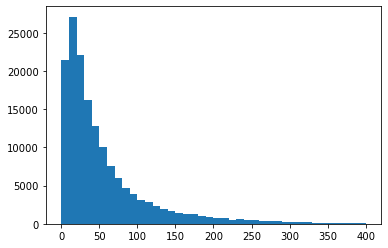

In [10]:
plt.hist(totalNumWords, bins=np.arange(0,410,10)) #[0,50,100, ~ 400]
plt.show()

대부분의 문장 길이는 약 30+이다. 'maxlen'을 약 50으로 설정할 수 있지만 200으로 설정했다.

### Finally the start of building model

쉼표 뒤에 빈 칸을 표시해 keras가 숫자를 자동으로 유추하도록 한다.

In [11]:
inp = Input(shape=(maxlen,))

다음으로, 이것을 임베딩 레이어로 전달하고, 문장에서 주변 단어의 거리에 따라 단어를 정의된 벡터 공간에 투영한다. 임베딩을 사용하면 모델 크기를 줄일 수 있으며, 가장 중요한 것은 문장의 단어를 표현하기 위해 one-hot encoding을 사용하는 경우 처리해야하는 엄청난 차원을 줄일 수 있다. 임베딩 레이어의 출력은 이 벡터 공간에 있는 단어의 좌표 목록일 뿐이다. 예를 들어, 'cat'의 (-81.012)와 'dog'의 (-80.012)다. 또한 이러한 좌표의 거리를 사용해 관련성과 맥락을 감지할 수 있다. 

위에서 언급한 '벡터 공간'의 크기와 사용하고있는 고유 단어(max_ features)의 수를 정의할 필요가 있다. 다시, 임베딩 크기는 조정 및 실험할 수 있는 매개 변수다.

In [12]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

임베딩 레이어는 (None, 200, 128)의 3D tensor를 출력한다. 이는 문장 배열이며 각 단어(200)에 대해 128개의 좌표 배열이 임베딩의 벡터 공간에 잇다.

다음으로 이 Tensor를 LSTM 레이어에 제공한다. LSTM을 60 차원을 가진 출력을 생성하도록 설정하고 LSTM이 결과의 전체 unrolled sequence를 반환하기 원한다. 아마 알고 있듯, LSTM이나 RNN은 이전 네트워크 출력을 현재 네트워크의 입력으로 재귀적으로 제공해 작동하며, X개의 재귀 후 최종 출력을 한다. 그러나 사용 사례에 따라 롤링되지 않은 또는 재귀의 출력을 결과로 가져와 다음 레이어로 전달할 수 있다.

In [13]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

In [14]:
x = GlobalMaxPool1D()(x)

In [15]:
x = Dropout(0.1)(x)

### Activation ((Input X Weights) + Bias)

In [16]:
x = Dense(50, activation='relu')(x)

In [17]:
x = Dropout(0.1)(x)

In [18]:
x = Dense(6, activation='sigmoid')(x)

In [19]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
             optimizer='adam', metrics=['accuracy'])

In [20]:
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 727s 161ms/step - loss: 0.1109 - accuracy: 0.8396 - val_loss: 0.0495 - val_accuracy: 0.9937
Epoch 2/2
4488/4488 [==============================] - 702s 156ms/step - loss: 0.0459 - accuracy: 0.9919 - val_loss: 0.0494 - val_accuracy: 0.9933


### Additional tips and tricks

1. 특히 차원 관련 오류를 반환하기 시작할 때 일부 장애물에 부딪힌 경우 'model.summary()'를 실행하는 것이 좋다. 진단에 매우 유용한 모든 레이어 출력을 나열하기 때문이다.

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

2. 더 많은 레이어를 추가하고 화려하게 변환하는 동안, 예상대로 출력이 작동하는지 확인하는 게 좋다. 다음을 통해 특정 레이어의 출력을 표시할 수 있다.

In [22]:
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input],
                                 [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 200, 60)